计算网络邻接矩阵

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from function import cal_dist

In [2]:
lon_lat = pd.read_csv('data\\lonlat.csv', encoding='GBK').values
dt_car = pd.read_csv('data\\CW.csv', encoding='GBK').values
dt_gdp = pd.read_csv('data\\GW.csv', encoding='GBK').values
dt_pop = pd.read_csv('data\\PW.csv', encoding='GBK').values
gdp_rj = pd.read_csv('data\\PGW.csv', encoding='GBK').values

In [3]:
pcg = dt_pop ** (1 / 3) * dt_car ** (1 / 3) * dt_gdp ** (1 / 3)
dist = cal_dist(lon_lat)

dist += np.eye(112) # *np.nan

In [4]:
num = 112
year_num = 10
year_begin = 2011

In [ ]:
net_dist = []
mats = []
for y in range(year_num):
    m = pcg[:, [y]]
    carbon = dt_car[:, [y]]
    
    ad = gdp_rj[:, [y]]
    kij = carbon / (carbon + carbon.T)
    yij = kij * (m * m.T) * (ad - ad.T) ** 2 / dist ** 2
    # yij = (1. - np.eye(41)) * kij * (m * m.T) / dist ** 2
    t1 = yij / 1.
    # pd.DataFrame(t1).to_csv(f'C:\\Users\\YihengSu\\Desktop\\强度矩阵\\net{year_begin + y}.csv', sep=',', index=False, header=False, encoding='GBK')

    t2 = np.mean(t1, axis=1).reshape(-1, 1) * num / (num-1)
    t3 = t1 - t2
    t3[t3 > 0] = 1
    t3[t3 < 0] = 0
    
    # yij = np.sqrt(kij * (m * m.T)) / dist
    # print(np.count_nonzero(yij ** 0.5 + np.eye(num)))
    t4 = (1. - np.eye(num)) / ( (yij ** 0.5 + np.eye(num)+1e-20)/np.mean(yij ** 0.5, axis=1).reshape(-1, 1))
    # t4 = t4 ** 0.5
    # t4 = np.exp(-(yij ** 0.5 + np.eye(41)) / np.mean(yij, axis=1).reshape(-1, 1))
    a = np.partition(t4, int(num*0.95), axis=1)[:, :int(num*0.95)+1]
    threshold = np.mean(a, axis=1) + 3 *  np.std(a, axis=1)
    for i in range(num):
        t4[i, t4[i] > threshold[i]] = threshold[i]
    print(y, np.max(t4))
    net_dist.append(t4)
    mats.append(t3)
net_dist = np.array(net_dist)
mats = np.array(mats).astype(int)
print(mats.shape)
dic = {'net_dist': net_dist, 'mats': mats}
np.save('my_file_csj.npy', dic)
net_dist[0]

"\n    t2 = np.mean(t1, axis=1).reshape(-1, 1) * num / (num-1)\n    t3 = t1 - t2\n    t3[t3 > 0] = 1\n    t3[t3 < 0] = 0\n    \n    # yij = np.sqrt(kij * (m * m.T)) / dist\n    # print(np.count_nonzero(yij ** 0.5 + np.eye(num)))\n    t4 = (1. - np.eye(num)) / ( (yij ** 0.5 + np.eye(num)+1e-20)/np.mean(yij ** 0.5, axis=1).reshape(-1, 1))\n    # t4 = t4 ** 0.5\n    # t4 = np.exp(-(yij ** 0.5 + np.eye(41)) / np.mean(yij, axis=1).reshape(-1, 1))\n    a = np.partition(t4, int(num*0.95), axis=1)[:, :int(num*0.95)+1]\n    threshold = np.mean(a, axis=1) + 3 *  np.std(a, axis=1)\n    for i in range(num):\n        t4[i, t4[i] > threshold[i]] = threshold[i]\n    print(y, np.max(t4))\n    net_dist.append(t4)\n    mats.append(t3)\nnet_dist = np.array(net_dist)\nmats = np.array(mats).astype(int)\nprint(mats.shape)\ndic = {'net_dist': net_dist, 'mats': mats}\nnp.save('my_file_csj.npy', dic)\nnet_dist[0]"

In [57]:
name = pd.read_csv('data/cityname.csv', encoding='GBK')['city'].values
for i in range(year_num):
    df = pd.DataFrame(mats[i], index=name, columns=name)
    df.to_csv(f'.\\net\\net{year_begin + i}.csv', sep=',', index=True, header=True, encoding='GBK')

总体网络特征

In [58]:
import networkx as nx

# df_base = pd.read_csv('data\\csj_0_基础信息.csv', encoding='GBK')
a = []

for i in range(year_num):
    G = nx.from_numpy_array(mats[i], create_using=nx.DiGraph())
    # pos = nx.spring_layout(G)  # 使用spring布局算法计算节点位置
    # nx.draw(G, pos, node_color='skyblue', node_size=20, edge_color='gray')
    # plt.title('Graph Visualization')
    # plt.show()
    a .append(nx.density(G))
d = np.array(a)

In [61]:
from glob import glob
import re
import os

out = []
files = glob('.\\net\\总体网络属性\\*.*')
for file in files:
    with open(file,encoding='ANSI') as f:
        data = f.read().replace(' ', '').replace('\n', '')

        year = re.search(r"net(\d\d\d\d)", data).group(1)
        h = re.search(r"Hierarchy(.*?)Efficiency", data).group(1)
        e = re.search(r"Efficiency(.*?)LUB", data).group(1)

        out.append([float(year), float(h), float(e)])
    os.rename(file, f'.\\net\\总体网络属性\\{year}.txt')
out = np.array(out)
df = pd.DataFrame(out, columns=['year', 'hierarchy', 'efficiency'])
df = df.sort_values('year', ignore_index=True)
df['density'] = d
df.to_csv('data\\总体网络属性.csv', index=False)
df

,year,hierarchy,efficiency,density
0,2011.0,0.1954,0.7985,0.129102
1,2012.0,0.1806,0.7967,0.130550
2,2013.0,0.1652,0.8023,0.127494
3,2014.0,0.1499,0.8064,0.125080
4,2015.0,0.1499,0.7990,0.129987
5,2016.0,0.1655,0.8013,0.128781
6,2017.0,0.1656,0.7943,0.133205
7,2018.0,0.1652,0.7889,0.135537
8,2019.0,0.1652,0.7810,0.140203
9,2020.0,0.1503,0.7792,0.140122


In [65]:
import networkx as nx

# df_base = pd.read_csv('data\\基础信息.csv', encoding='GBK')
df_degree = pd.DataFrame()
df_closeness = pd.DataFrame()
df_betweenness = pd.DataFrame()

for i in range(year_num):
    G = nx.from_numpy_array(mats[i], create_using=nx.DiGraph())
    pos = nx.spring_layout(G)  # 使用spring布局算法计算节点位置
    # nx.draw(G, pos, node_color='skyblue', node_size=20, edge_color='gray')
    # plt.title('Graph Visualization')
    # plt.show()
    df_degree[f'{2011+i}'] = np.array(list(nx.degree_centrality(G).values()))
    df_closeness[f'{2011+i}'] = np.array(list(nx.closeness_centrality(G).values()))
    df_betweenness[f'{2011+i}'] = np.array(list(nx.betweenness_centrality(G).values()))
df_degree.to_csv('data\\度中心性.csv', index=False)
df_closeness.to_csv('data\\接近中心性.csv', index=False)
df_betweenness.to_csv('data\\中介中心性.csv', index=False)

组合面板数据

In [11]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# gdp = pd.read_csv('data\\csj_GDP(亿元).csv').values[:, 4:].T.reshape(-1, 1)
# pop = pd.read_csv('data\\csj_常住人口(万人).csv').values[:, 4:].T.reshape(-1, 1)
# popDensity = pd.read_csv('data\\csj_人口密度(人每平方公里).csv').values[:, 4:].T.reshape(-1, 1)
# constructionLand = pd.read_csv('data\\csj_城市建设用地面积(平方公里).csv').values[:, 4:].T.reshape(-1, 1)
# urbanizationRate = pd.read_csv('data\\csj_城镇化率.csv').values[:, 4:].T.reshape(-1, 1)
# buildingHeight = pd.read_csv('data\\csj_城市建筑平均高度(m).csv').values[:, 4:].T.reshape(-1, 1)
# degreeCentrality = pd.read_csv('data\\csj_度中心性.csv').values[:, 4:].T.reshape(-1, 1)
# closenessCentrality = pd.read_csv('data\\csj_接近中心性.csv').values[:, 4:].T.reshape(-1, 1)
# betweennessCentrality = pd.read_csv('data\\csj_中介中心性.csv').values[:, 4:].T.reshape(-1, 1)

# carbonEmission = pd.read_csv('data\\csj_建筑碳排放(万吨).csv').values[:, 4:].T.reshape(-1, 1)

In [12]:
# base = pd.read_csv('data\\csj_0_基础信息.csv', encoding='GBK')[['ID', 'code', 'lon', 'lat']].values
# base = np.tile(base, (16, 1))

# time = np.arange(2006, 2022).reshape(-1, 1)
# time = np.repeat(time, 41, axis=0)
# data = np.concatenate((base, time, gdp, pop, popDensity, constructionLand, urbanizationRate, buildingHeight, degreeCentrality, closenessCentrality, betweennessCentrality, carbonEmission), axis=1)
# pd.DataFrame(data, columns=['ID', 'code', 'lon', 'lat', 'T', 'GDP', 'pop', 'popDensity', 'constructionLand', 'urbanizationRate', 'buildingHeight', 'degreeCentrality', 'closenessCentrality', 'betweennessCentrality', 'carbonEmission']).to_csv(f'data\\面板数据.csv', index=False)

计算网络距离矩阵

207.7537308762356 7.214135552410693 (10, 112, 112)


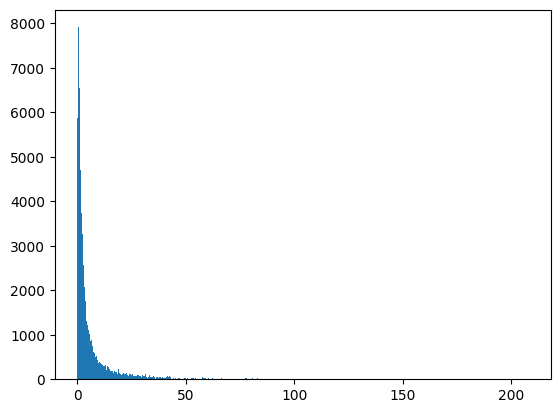

In [6]:
net_dist = np.load('my_file_csj.npy', allow_pickle=True).item()['net_dist']
print(net_dist.max(), net_dist.mean(), net_dist.shape)
plt.hist(net_dist.flatten(), 1000)
plt.show()

In [7]:
l = net_dist.mean() / (year_num-1)
def cal_i(y1, i1):
    d1 = net_dist[y1, i1]
    d2 = net_dist[:, i1]
    t = (np.linspace(0, (year_num-1), year_num) - y1) * l
    out1 = np.sqrt((d1 ** 2 + d2 ** 2) / 2 + t.reshape(-1, 1) ** 2).flatten()
    return out1

In [ ]:
a= np.loadtxt('data\\Correction_factor_indi.csv', delimiter=',')
# b = 1-a*0.1
# c = np.tile(b, (16, 16))

c = 1.0001 - 0.0001 * a
c

array([[0.98, 1.02, 1.02, ..., 1.02, 1.02, 0.98],
       [1.02, 0.98, 0.98, ..., 0.98, 0.98, 1.02],
       [1.02, 0.98, 0.98, ..., 1.  , 1.  , 1.02],
       ...,
       [1.02, 0.98, 1.  , ..., 0.98, 0.98, 1.02],
       [1.02, 0.98, 1.  , ..., 0.98, 0.98, 1.02],
       [0.98, 1.02, 1.02, ..., 1.02, 1.02, 0.98]])

In [10]:
dist.mean()

7120.864785038663

In [11]:
w = []
for i in range(year_num):
    for j in range(num):
        w.append(cal_i(i, j))
print(np.mean(w))
w = np.array(w) * 7120865 / 8.75

np.savetxt('data\\网络距离矩阵_无聚类.csv', w, fmt='%.4f', delimiter=',')

8.750456105625146


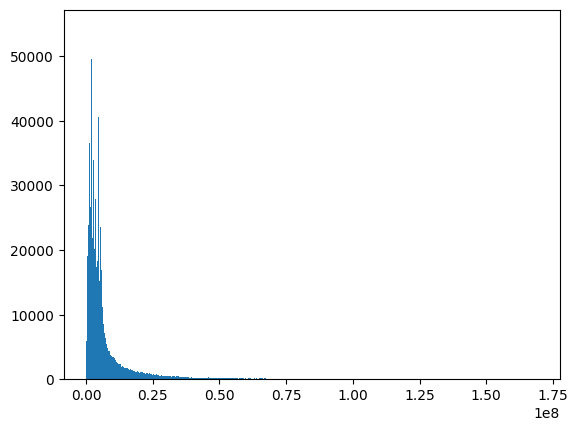

In [12]:
plt.hist(w.flatten(), 1000)
plt.show()

In [13]:
np.mean(w)

7121236.184752272

In [14]:
w = w * c
np.savetxt('data\\网络距离矩阵.csv', w, fmt='%.4f', delimiter=',')

计算时空距离矩阵

In [1]:
import numpy as np
import pandas as pd

def phy_dist(coords, tau=377708034):
    dLon = np.radians(coords[:, [0]] - coords[:, [0]].T)
    dLat = np.radians(coords[:, [1]] - coords[:, [1]].T)
    lat = np.radians(coords[:, [1]])
    a = np.sin(dLat / 2) ** 2 + np.cos(lat) * np.cos(lat.T) * np.sin(dLon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    R = 6371000.0
    return np.sqrt((R * c) ** 2 + tau * (coords[:, [2]] - coords[:, [2]].T) ** 2)

In [2]:
data = pd.read_csv('data\\STNWR运行数据集.csv')
coords = data[['Lon', 'Lat', 'T']].values
D = phy_dist(coords)
print(D.shape)
pd.DataFrame(D).to_csv('data\\地理距离矩阵.csv', index=False, header=False)

(1120, 1120)
